<a href="https://colab.research.google.com/github/lawgorithm/large_scale_inference/blob/main/Normal_Normal_Empirical_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References on empirical bayes

https://nignatiadis.github.io/assets/lecture_notes/Empirical-Bayes.pdf



# Normal-Normal Model

Data generating process:

$$y_i \mid \theta_i \sim N(\theta_i, V_i) $$
$$\theta_i \sim N(\mu, \tau^2) $$

Marginally:

$$ y_i \sim N(\mu, V_i + \tau^2) $$

Posterior mean:

$$ E(\theta_i \mid y_i) = \mu + \frac{\tau^2}{\tau^2 + V_i} (y_i - \mu)$$

Posterior Variance:
$$ Var(θ_i | y_i) = \frac{1}{\frac{1}{τ^2} + \frac{1}{V_i}}  = \frac{τ^2 V_i}{τ^2 + V_i} $$





In [1]:
# Install NumPyro and JAX if you haven't already
!pip install numpyro[jax] --quiet
!pip install gurobipy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import gurobipy as gp
from gurobipy import GRB

# Empirical Bayes estimation

To estimate the prior parameters $\mu$ and $\tau^2$ we will perform maximum likelihood inference using the marginal distribution for $y_i$, treating the observed standard errors, $V_i$, and fixed, known quantities

We then plug-in the MLE estimates for the prior parameters into the posterior to get the posterior mean and variance under the normal-normal model.

In [3]:
def neg_log_likelihood(params, y, SE):
  """
  Calculates the negative log-likelihood corresponding to the marginal
  distribution of y_i. The likelihood is a function of mu, tau2, and V_i.

  Args:
      params (array): A tuple or list containing the model parameters:
          - mu (float): The mean of the normal distribution.
          - tau2 (float): The additional variance component.
      y (array): The observeds data -- point estimates for the mean
      SE (array): The standard errors of the point estimates

  Returns:
      float: The negative log-likelihood.  Returns infinity if tau2 is negative.
  """
  mu, tau2 = params[0], params[1]
  # Return infinity for invalid variance
  if tau2 < 0:
    return np.inf

  # Marginal variance of y_i
  var = SE**2 + tau2
  # Negative log-likelihood
  nll = 0.5 * np.sum(np.log(2 * np.pi * var) + (y - mu)**2 / var)
  return nll

def eb_normal_normal(y, SE):
  """
  Performs Empirical Bayes estimation for a Normal-Normal hierarchical model.

  Args:
      y (array-like): The observed data (y_i) -- point estimates for the mean
      SE (array-like or float): The standard errors associated with y

  Returns:
      tuple: A tuple containing:
          - mu_hat (float): The estimated prior mean (mu).
          - tau2_hat (float): The estimated prior variance (tau^2).
          - theta_hat (array-like): The estimated posterior means (theta_i).
          - post_var (array-like or float): The posterior variance(s).
  """
  # Initial guess for the prior mean. Recall E(y) = mu
  mu0 = np.mean(y)
  # Recall marginal variance: V(y_i) = tau^2 + SE_i^2
  # ensuring it's non-negative (at least 0.1).
  tau2_0 = max(0.1, np.var(y) - np.mean(SE**2))

  # Numerically minimize the negative log-likelihood to (equivilently) obtain
  # the MLE for mu and tau^2
  res = minimize(
      neg_log_likelihood,
       [mu0, tau2_0],
      args=(y, SE),
      bounds=[(None, None), (0, None)])
  mu_hat, tau2_hat = res.x

  # Compute the EB posterior mean for each experiment
  theta_hat = mu_hat + (tau2_hat / (tau2_hat + SE**2)) * (y - mu_hat)

  # Compute the posterior variance
  post_var = 1 / (1 / tau2_hat + 1 / SE**2)

  return mu_hat, tau2_hat, theta_hat, post_var

# Simulate observed data

In [4]:
def generate_normal_normal_samples(n_samples, mu, tau2):
    """
    Generates samples from a Normal-Normal hierarchical model.  V is simulated
    sampled from an Inverse Gamma distribution.

    Args:
        n_samples (int): The number of samples to generate.
        mu (float): The prior mean of theta.
        tau2 (float): The prior variance of theta.

    Returns:
        tuple: A tuple containing:
            - theta (array-like): The generated theta values.
            - y (array-like): The generated y values.
            - V (array-like): The generated V values (observation variances).
    """

    # Generate theta values from the prior distribution
    theta = np.random.normal(mu, np.sqrt(tau2), n_samples)

    # Simulate V values from an Inverse Gamma distribution (example prior)
    alpha = 5  # Shape parameter for the Inverse Gamma
    beta = 5   # Scale parameter for the Inverse Gamma
    V = 1.0 / np.random.gamma(alpha, 1.0 / beta, n_samples)

    # Generate y values from the conditional distribution (vectorized)
    y = np.random.normal(theta, np.sqrt(V))

    return theta, y, V

In [5]:
# Example usage:
n_samples = 100
mu = 0
tau2 = 2

theta, y, V = generate_normal_normal_samples(n_samples, mu, tau2)

np.quantile(V, [0.025, 0.975])

# # You can adjust the alpha and beta parameters to change the prior on V.
# # For example, to have more concentrated values around a mean of 1:
# alpha2 = 10
# beta2 = 10
# theta2, y2, V2 = generate_normal_normal_samples(n_samples, mu, tau2)
# print("\nGenerated V2 (first 10, different prior):\n", V2[:10])

df = pd.DataFrame(
    {
        "true_theta": theta,
        "y": y,
        "SE": V**0.5
    }
)

# Do MLE and EB inference on the simulated data

In [6]:
mu_hat, tau2_hat, theta_hat, post_var = eb_normal_normal(
    y = df['y'],
    SE = df['SE']
)

In [7]:
df['theta_hat_EB'] = theta_hat
df['theta_post_var'] = post_var
df['EB_Cred_Int_Low'] = df['theta_hat_EB'] - 1.96 * post_var**0.5
df['EB_Cred_Int_High'] = df['theta_hat_EB'] + 1.96 * post_var**0.5
df['CI_Low'] = df['y'] - 1.96 * df['SE']
df['CI_High'] = df['y'] + 1.96 * df['SE']
df['CI_covers'] = (
    (df['CI_Low'] <= df['true_theta']) &
    (df['CI_High'] >= df['true_theta'])
)
df['EB_credible_covers'] = (
    (df['EB_Cred_Int_Low'] <= df['true_theta']) &
    (df['EB_Cred_Int_High'] >= df['true_theta'])
)
df.head()

,true_theta,y,SE,theta_hat_EB,theta_post_var,EB_Cred_Int_Low,EB_Cred_Int_High,CI_Low,CI_High,CI_covers,EB_credible_covers
0,-0.246289,-0.422399,1.362427,-0.302549,0.861167,-2.121411,1.516313,-3.092756,2.247958,True,True
1,-1.528892,-0.105933,1.082518,-0.145112,0.677581,-1.758492,1.468268,-2.227667,2.015802,True,True
2,-1.042505,0.276298,1.304710,0.031859,0.826492,-1.750008,1.813726,-2.280934,2.833530,True,True
3,1.574947,-0.363297,1.605184,-0.261988,0.989523,-2.211693,1.687717,-3.509458,2.782864,True,True
4,0.677798,-0.152631,0.871422,-0.167457,0.515636,-1.574890,1.239975,-1.860617,1.555356,True,True


# Assess estimates

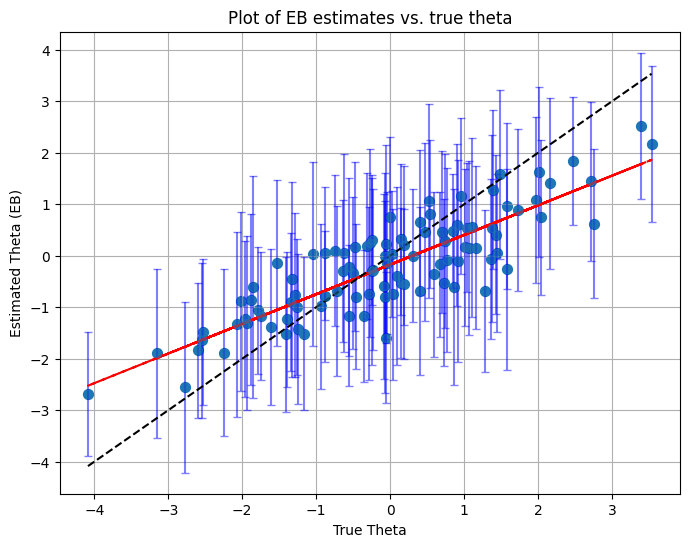

In [8]:
# Create the plot
plt.figure(figsize=(8, 6))  # Optional: Adjust figure size
plt.scatter(
    df['true_theta'],
    df['theta_hat_EB'],
    marker='o',
    s=50) # Use scatter plot for individual points, s controls size

# Plot credible intervals
plt.errorbar(
    df['true_theta'],
    df['theta_hat_EB'],
    yerr=np.array(
        [df['theta_hat_EB'] - df['EB_Cred_Int_Low'],
         df['EB_Cred_Int_High'] - df['theta_hat_EB']]),
    fmt='o',
    ecolor='b',
    capsize=3,
    alpha=0.5,
    label="95% CI")

# Add labels and title
plt.xlabel("True Theta")
plt.ylabel("Estimated Theta (EB)")
plt.title("Plot of EB estimates vs. true theta")

# Add a trend line (optional)
z = np.polyfit(df['true_theta'], df['theta_hat_EB'], 1) # Fit a 1st degree polynomial (linear)
p = np.poly1d(z)
plt.plot(df['true_theta'], p(df['true_theta']), "r--") # Plot the trend line in red and dashed

# Plot the x=y line (identity line)
plt.plot([df['true_theta'].min(), df['true_theta'].max()],  # x-coordinates
         [df['true_theta'].min(), df['true_theta'].max()],  # y-coordinates
         'k--',  # Black, dashed line
         label="x=y Line")  # Label for the legend

# Add grid lines (optional)
plt.grid(True)

# Show the plot
plt.show()

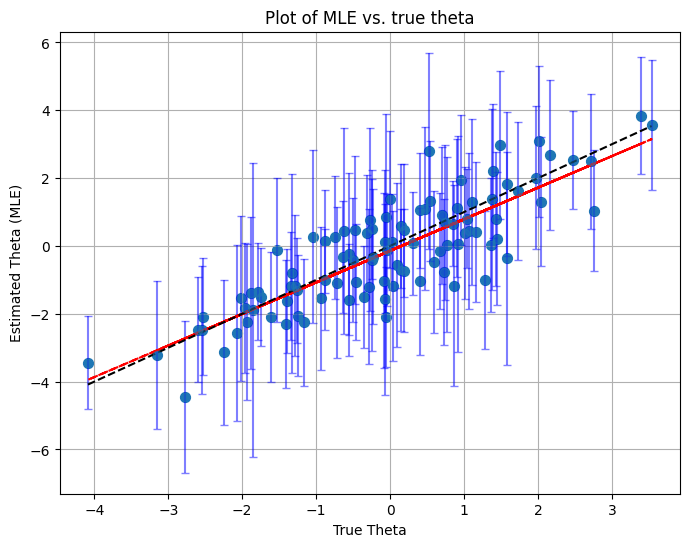

In [9]:
# Create the plot
plt.figure(figsize=(8, 6))  # Optional: Adjust figure size
plt.scatter(
    df['true_theta'],
    df['y'],
    marker='o',
    s=50) # Use scatter plot for individual points, s controls size

# Plot CIs
plt.errorbar(
    df['true_theta'],
    df['y'],
    yerr=np.array([df['y'] - df['CI_Low'], df['CI_High'] - df['y']]),
    fmt='o',
    ecolor='b',
    capsize=3,
    alpha=0.5,
    label="95% CI")

# Add labels and title
plt.xlabel("True Theta")
plt.ylabel("Estimated Theta (MLE)")
plt.title("Plot of MLE vs. true theta")

# Add a trend line (optional)
z = np.polyfit(df['true_theta'], df['y'], 1) # Fit a 1st degree polynomial (linear)
p = np.poly1d(z)
plt.plot(df['true_theta'], p(df['true_theta']), "r--") # Plot the trend line in red and dashed

# Plot the x=y line (identity line)
plt.plot([df['true_theta'].min(), df['true_theta'].max()],  # x-coordinates
         [df['true_theta'].min(), df['true_theta'].max()],  # y-coordinates
         'k--',  # Black, dashed line
         label="x=y Line")  # Label for the legend

# Add grid lines (optional)
plt.grid(True)

# Show the plot
plt.show()

In [10]:
#@title Assess bias, variance, MSE of the MLE and EB estimates. EB has best MSE

# Calculate and print the bias of EB theta estimates
bias_eb = np.mean((df['theta_hat_EB'] - df['true_theta']))
print(f"Bias of EB theta estimates: {bias_eb}")

# Calculate and print the bias of MLE theta estimates
bias_mle = np.mean((df['y'] - df['true_theta']))
print(f"Bias of MLE theta estimates: {bias_mle}")

# Calculate and print the variance of the error in MLE estimates
variance_mle_error = np.var((df['y'] - df['true_theta']))
print(f"Variance of MLE error: {variance_mle_error}")

# Calculate and print the variance of the error in EB theta estimates
variance_eb_error = np.var((df['theta_hat_EB'] - df['true_theta']))
print(f"Variance of EB error: {variance_eb_error}")

# Calculate and print the mean squared error of MLE estimates
mse_mle = np.mean((df['y'] - df['true_theta'])**2)
print(f"Mean squared error of MLE: {mse_mle}")

# Calculate and print the mean squared error of EB theta estimates
mse_eb = np.mean((df['theta_hat_EB'] - df['true_theta'])**2)
print(f"Mean squared error of EB: {mse_eb}")

assert (bias_mle**2 + variance_mle_error) - mse_mle < 10**-5
assert (bias_eb**2 + variance_eb_error) - mse_eb < 10**-5

Bias of EB theta estimates: -0.15145356144521624
Bias of MLE theta estimates: -0.1395155830932428
Variance of MLE error: 0.7638424642501782
Variance of EB error: 0.6417409225591519
Mean squared error of MLE: 0.7833070621760256
Mean squared error of EB: 0.664679103833592


In [11]:
#@title Coverage of CIs and credible intervals
CI_coverage = np.mean(df['CI_covers'])
EB_coverage = np.mean(df['EB_credible_covers'])
print(f"CI coverage: {CI_coverage}")
print(f"EB coverage: {EB_coverage}")

mean_CI_width = np.mean(df['CI_High'] - df['CI_Low'])
mean_EB_width = np.mean(df['EB_Cred_Int_High'] - df['EB_Cred_Int_Low'])
print(f"Mean CI width: {mean_CI_width}")
print(f"Mean EB width: {mean_EB_width}")

CI coverage: 0.98
EB coverage: 0.96
Mean CI width: 4.138495650410352
Mean EB width: 3.122153613642828


In [12]:
#@title Assess estimates of the prior parameters

print(f"True mu: {mu}, Estimated mu_hat: {mu_hat}")
print(f"True tau2: {tau2}, Estimated tau2_hat: {tau2_hat}")

bias_mu = mu_hat - mu
print(f"Bias of mu_hat: {bias_mu}")

bias_tau2 = tau2_hat - tau2
print(f"Bias of tau2_hat: {bias_tau2}")

True mu: 0, Estimated mu_hat: -0.19882326443508033
True tau2: 2, Estimated tau2_hat: 1.606471285112325
Bias of mu_hat: -0.19882326443508033
Bias of tau2_hat: -0.39352871488767494


# Simulate from posterior

In [13]:
df_small = df[['theta_hat_EB', 'theta_post_var']].copy()
df_small['id'] = range(df_small.shape[0])
df_small.head()

,theta_hat_EB,theta_post_var,id
0,-0.302549,0.861167,0
1,-0.145112,0.677581,1
2,0.031859,0.826492,2
3,-0.261988,0.989523,3
4,-0.167457,0.515636,4


In [14]:
%%time

num_samples = int(1e6)
# To vectorize, repeat the rows for as many samples as you want for each id
df_repeated = df_small.loc[
    df_small.index.repeat(num_samples)].reset_index(drop=True)
df_repeated['theta_sample'] = np.random.normal(
    loc=df_repeated['theta_hat_EB'],
    scale=np.sqrt(df_repeated['theta_post_var'])
)
df_repeated.drop(columns=['theta_hat_EB', 'theta_post_var'], inplace=True)

CPU times: user 15.5 s, sys: 4.43 s, total: 19.9 s
Wall time: 28 s


In [15]:
# Verify correctness
mean_res = df_repeated.groupby(['id']).mean()
mean_res.rename(columns={'theta_sample': 'monte_carlo_mean'}, inplace=True)
mean_res.reset_index(inplace=True)
var_res = df_repeated.groupby(['id']).var()
var_res.rename(columns={'theta_sample': 'monte_carlo_var'}, inplace=True)
var_res.reset_index(inplace=True)
df_repeated.merge(mean_res, on='id').merge(var_res, on='id')

,id,theta_sample,monte_carlo_mean,monte_carlo_var
0,0,1.748262,-0.301808,0.861138
1,0,-1.437156,-0.301808,0.861138
2,0,-0.475196,-0.301808,0.861138
3,0,0.582011,-0.301808,0.861138
4,0,-0.128088,-0.301808,0.861138
...,...,...,...,...
99999995,99,-0.084245,0.533112,0.857484
99999996,99,-0.507725,0.533112,0.857484
99999997,99,0.107073,0.533112,0.857484
99999998,99,1.265215,0.533112,0.857484


# Compare to James-Stein

For heteroscedastic James-Stein, we assume:

$$y_i \sim N(\theta_i, \sigma^2_i)$$

where the variances $\sigma^2_i$ are known. This is important because the estimator will typically use inverse-variance weighting or a transformation that standardizes the errors. While the normal-normal empirical Bayes model assumes a specific hierarchical structure (true effects drawn from a normal distribution and known variances), the James-Stein estimator doesn't assume a prior.

J-S is often used as a baseline because it provides stable estimates without requiring complex modeling, making it a reliable “workhorse” estimator.

In [16]:
def james_stein_estimator(y, SE):
    """
    Computes the James–Stein estimates for a set of estimates with corresponding standard errors.

    Parameters:
      y: numpy array of observed point estimates.
      SE: numpy array of standard errors.

    Returns:
      theta_hat: James–Stein estimates (shrunk values).
    """
    n = len(y)
    # Weighted mean using inverse variance weights
    weights = 1 / SE**2
    weighted_mean = np.sum(weights * y) / np.sum(weights)

    # Calculate the shrinkage factor
    sum_sq_diff = np.sum(weights * (y - weighted_mean)**2)
    shrinkage_factor = max(0, 1 - ((n - 2) / sum_sq_diff))

    # Compute James–Stein estimates
    theta_hat = weighted_mean + shrinkage_factor * (y - weighted_mean)
    return theta_hat

# Example usage:
y = np.array([0.5, 1.2, -0.3, 0.7, 1.0])      # Point estimates
sigma = np.array([0.2, 0.3, 0.25, 0.2, 0.3])   # Standard errors

theta_james_stein = james_stein_estimator(y, sigma)

print("James–Stein estimates:", theta_james_stein)


James–Stein estimates: [ 0.50984355  1.09998316 -0.16460171  0.67845487  0.93137185]


In [17]:
df['theta_hat_JS'] = james_stein_estimator(
    y = df['y'],
    SE = df['SE']
)

In [18]:
# Calculate and print the mean squared error of EB theta estimates
mse_eb = np.mean((df['theta_hat_EB'] - df['true_theta'])**2)
print(f"Mean squared error of EB: {mse_eb}")

mse_js = np.mean((df['theta_hat_JS'] - df['true_theta'])**2)
print(f"Mean squared error of JS: {mse_js}")

Mean squared error of EB: 0.664679103833592
Mean squared error of JS: 0.6839243304033846


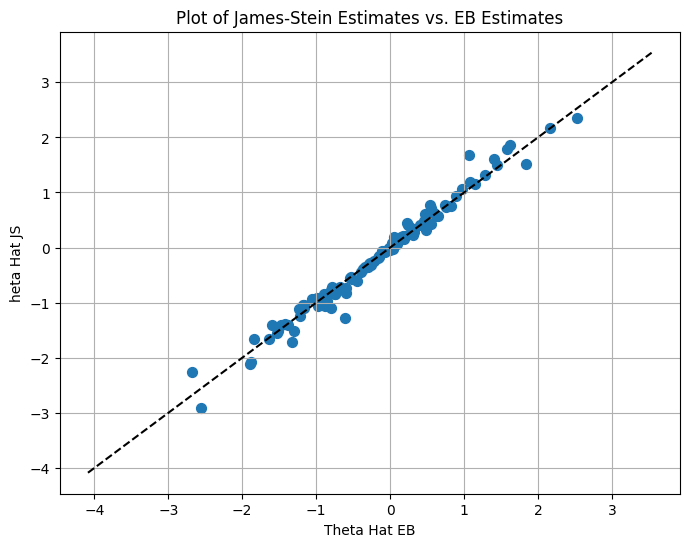

In [19]:
# Create the plot
plt.figure(figsize=(8, 6))  # Optional: Adjust figure size
plt.scatter(
    df['theta_hat_EB'],
    df['theta_hat_JS'],
    marker='o',
    s=50) # Use scatter plot for individual points, s controls size

# Add labels and title
plt.xlabel("Theta Hat EB")
plt.ylabel("heta Hat JS")
plt.title("Plot of James-Stein Estimates vs. EB Estimates")

# Plot the x=y line (identity line)
plt.plot([df['true_theta'].min(), df['true_theta'].max()],  # x-coordinates
         [df['true_theta'].min(), df['true_theta'].max()],  # y-coordinates
         'k--',  # Black, dashed line
         label="x=y Line")  # Label for the legend

# Add grid lines (optional)
plt.grid(True)

# Show the plot
plt.show()

# Contrast with full bayseian approach with hyperpriors

In [20]:
# Define the hierarchical model
def hierarchical_model(y, SE):
    # Hyperpriors for overall mean and between-experiment standard deviation.
    mu = numpyro.sample("mu", dist.Normal(0, 10))
    tau = numpyro.sample("tau", dist.HalfNormal(5))

    # Prior for true effects for each experiment.
    theta = numpyro.sample("theta", dist.Normal(mu, tau).expand([y.shape[0]]))

    # Likelihood: observed y's with known standard errors.
    with numpyro.plate("data", y.shape[0]):
        numpyro.sample("y_obs", dist.Normal(theta, SE), obs=y)

In [21]:
%%time

BURNIN=int(1e3)
NUM_SAMPLES=int(1e4)

# Run inference using NUTS (No-U-Turn Sampler)
nuts_kernel = NUTS(hierarchical_model)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=BURNIN,
    num_samples=NUM_SAMPLES)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, y=df['y'].values, SE=df['SE'].values)
mcmc.print_summary()

sample: 100%|██████████| 11000/11000 [00:15<00:00, 709.97it/s, 15 steps of size 3.58e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.20      0.17     -0.20     -0.46      0.08  13277.53      1.00
       tau      1.30      0.15      1.29      1.04      1.54   5567.02      1.00
  theta[0]     -0.29      0.97     -0.28     -1.89      1.28  23206.30      1.00
  theta[1]     -0.14      0.81     -0.14     -1.50      1.16  23749.52      1.00
  theta[2]      0.04      0.88      0.05     -1.40      1.47  23865.33      1.00
  theta[3]     -0.27      1.02     -0.27     -1.96      1.37  24849.25      1.00
  theta[4]     -0.17      0.74     -0.18     -1.34      1.10  23576.13      1.00
  theta[5]      0.49      0.57      0.49     -0.45      1.42  24135.34      1.00
  theta[6]     -0.53      0.86     -0.52     -1.91      0.88  23492.37      1.00
  theta[7]     -0.21      0.89     -0.22     -1.68      1.21  26371.71      1.00
  theta[8]     -0.09      0.93     -0.09     -1.63      1.42  23832.43      1.00
  theta[9]     -0.90      0

In [22]:
# Get posterior samples
posterior_samples = mcmc.get_samples()

# Calculate posterior means using jnp.mean (important!)
posterior_means = {}
for name, samples in posterior_samples.items():
    posterior_means[name] = jnp.mean(samples, axis=0)

# Access individual parameter means:
mu_mean = posterior_means["mu"]
tau_mean = posterior_means["tau"]
theta_means = posterior_means["theta"]

df['theta_hat_fullbayes'] = theta_means

In [23]:
# Calculate and print the mean squared error of EB theta estimates
mse_eb = np.mean((df['theta_hat_EB'] - df['true_theta'])**2)
print(f"Mean squared error of EB: {mse_eb}")

# Calculate and print the mean squared error of full bayes theta estimates
mse_full_bayes = np.mean((df['theta_hat_fullbayes'] - df['true_theta'])**2)
print(f"Mean squared error of full bayes: {mse_full_bayes}")

Mean squared error of EB: 0.664679103833592
Mean squared error of full bayes: 0.6606866523527376


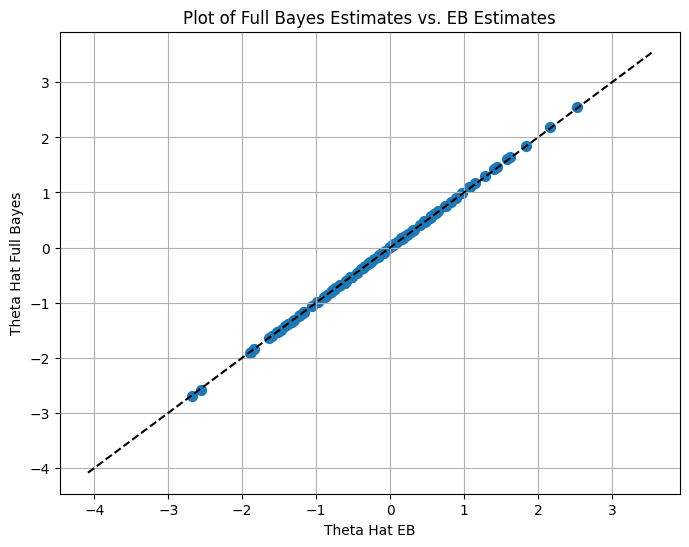

In [24]:
# Create the plot
plt.figure(figsize=(8, 6))  # Optional: Adjust figure size
plt.scatter(
    df['theta_hat_EB'],
    df['theta_hat_fullbayes'],
    marker='o',
    s=50) # Use scatter plot for individual points, s controls size

# Add labels and title
plt.xlabel("Theta Hat EB")
plt.ylabel("Theta Hat Full Bayes")
plt.title("Plot of Full Bayes Estimates vs. EB Estimates")

# Plot the x=y line (identity line)
plt.plot([df['true_theta'].min(), df['true_theta'].max()],  # x-coordinates
         [df['true_theta'].min(), df['true_theta'].max()],  # y-coordinates
         'k--',  # Black, dashed line
         label="x=y Line")  # Label for the legend

# Add grid lines (optional)
plt.grid(True)

# Show the plot
plt.show()

# Choosing arms

Suppose I have tuples (m, v) and I want to choose parameters b in {0,1) such that sum(b_i m_i) is maximized subject to the constraint that sum(b_i m_i) / sqrt(sum(b_i V_i)) > T, for some specified threshold T.

This type of problem is typically classified as a mixed-integer quadratically constrained program (MIQCP). In your case, you have binary (0-1) decision variables selecting a subset of items (tuples), and you impose a quadratic constraint—after squaring the ratio constraint—to ensure that the selected subset meets a performance threshold. In some contexts, especially when the constraint looks like a risk-return tradeoff (for example, resembling a Sharpe ratio constraint), it might also be called a quadratically constrained knapsack problem.

In [35]:
estimator = 'theta_hat_JS'
df_opt = df[df[estimator] >= 0.0].copy().reset_index(drop=True)

# Example data for n tuples (replace these with your actual numbers)
m = df_opt[estimator]
v = df_opt['SE']**2
T = 5

n = len(m)

# Create a new model
model = gp.Model("subset_selection")

# Create binary decision variables b[i] for each tuple
b = model.addVars(n, vtype=GRB.BINARY, name="b")

# Define expressions for the numerator and denominator
sum_m = gp.quicksum(m[i] * b[i] for i in range(n))
sum_v = gp.quicksum(v[i] * b[i] for i in range(n))

# Set the objective: maximize the total m value of the selected tuples
model.setObjective(sum_m, GRB.MAXIMIZE)

# Add the performance constraint:
#    (sum_m)^2 >= T^2 * sum_v
model.addQConstr(sum_m * sum_m >= (T**2) * sum_v, name="performance_constraint")

# Allow nonconvex quadratic constraints
model.params.NonConvex = 2

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found:")
    for i in range(n):
        print(f"Tuple {i}: b[{i}] = {b[i].X}")
    print("Objective (total m):", model.objVal)
else:
    print("No optimal solution found.")

Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
NonConvex  2

Optimize a model with 0 rows, 41 columns and 0 nonzeros
Model fingerprint: 0x97105dc1
Model has 1 quadratic constraint
Variable types: 0 continuous, 41 integer (41 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [2e-03, 1e+01]
  QLMatrix range   [1e+01, 6e+01]
  Objective range  [5e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve time: 0.00s
Presolved: 1641 rows, 861 columns, 4141 nonzeros
Variable types: 0 continuous, 861 integer (861 binary)

Root relaxation: objective 2.971273e+01, 485 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node

In [36]:
b_values = [b[i].X for i in range(n)]
df_opt['optimal_bundle'] = b_values

In [37]:
bundle_sum = np.sum(np.multiply(
    df_opt['theta_hat_JS'],
    df_opt['optimal_bundle']
))

In [38]:
bundle_SE = np.sqrt(np.sum(np.multiply(
    df_opt['SE']**2,
    df_opt['optimal_bundle']
)))

In [39]:
bundle_sum / bundle_SE

5.003699207978694